In [1]:
import xarray as xr
import os
import dfm_tools as dfmt
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from IPython.display import HTML
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
#import geopandas as gpd
import pandas as pd
from matplotlib.gridspec import GridSpec

c:\Users\aleksand\AppData\Local\mambaforge\envs\dfm_tools_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir_runs = r'p:\11210471-001-compass\02_Models\Delft3DFM\mozambique_model\computations'
#model = 'mozambique_spw_Idai_areaBeira_500m_gebco2023_test_newSPW' 
model = 'mozambique_spw_Idai_areaBeira_500m_gebco2023_test_newSPW'

In [3]:
# locate his file
for fname in os.listdir(os.path.join(dir_runs,model,'output')):
    if fname.endswith('_his.nc'):
        file_nc_his = os.path.join(dir_runs,model,'output',fname)

In [4]:
# locate map files 
file_nc_map = []
for fname in os.listdir(os.path.join(dir_runs,model,'output')):
    if fname.endswith("map.nc"):
        print(fname)
        file_nc_map.append(os.path.join(dir_runs,model,'output',fname))

mozambique_spw_Idai_areaBeira_500m_gebco2023_0000_map.nc
mozambique_spw_Idai_areaBeira_500m_gebco2023_0001_map.nc
mozambique_spw_Idai_areaBeira_500m_gebco2023_0002_map.nc
mozambique_spw_Idai_areaBeira_500m_gebco2023_0003_map.nc


In [5]:
ds_his = xr.open_dataset(file_nc_his)

In [6]:
ds_map = dfmt.open_partitioned_dataset(file_nc_map)

>> xu.open_dataset() with 4 partition(s): 1 2 3 4 : 7.48 sec
>> xu.merge_partitions() with 4 partition(s): 1.10 sec
>> dfmt.open_partitioned_dataset() total: 8.58 sec


In [7]:
# compute magnitude of wind
ds_map['mesh2d_windmag'] = np.sqrt(ds_map['mesh2d_windx']**2 + ds_map['mesh2d_windy']**2)

In [8]:
#ds_map


In [ ]:
# Plot bathymetry
fig, ax = plt.subplots(1,1,figsize=(10,7),sharex=True,sharey=True)
pc = ds_map['mesh2d_flowelem_bl'].ugrid.plot(ax=ax, cmap='jet',vmax=0)

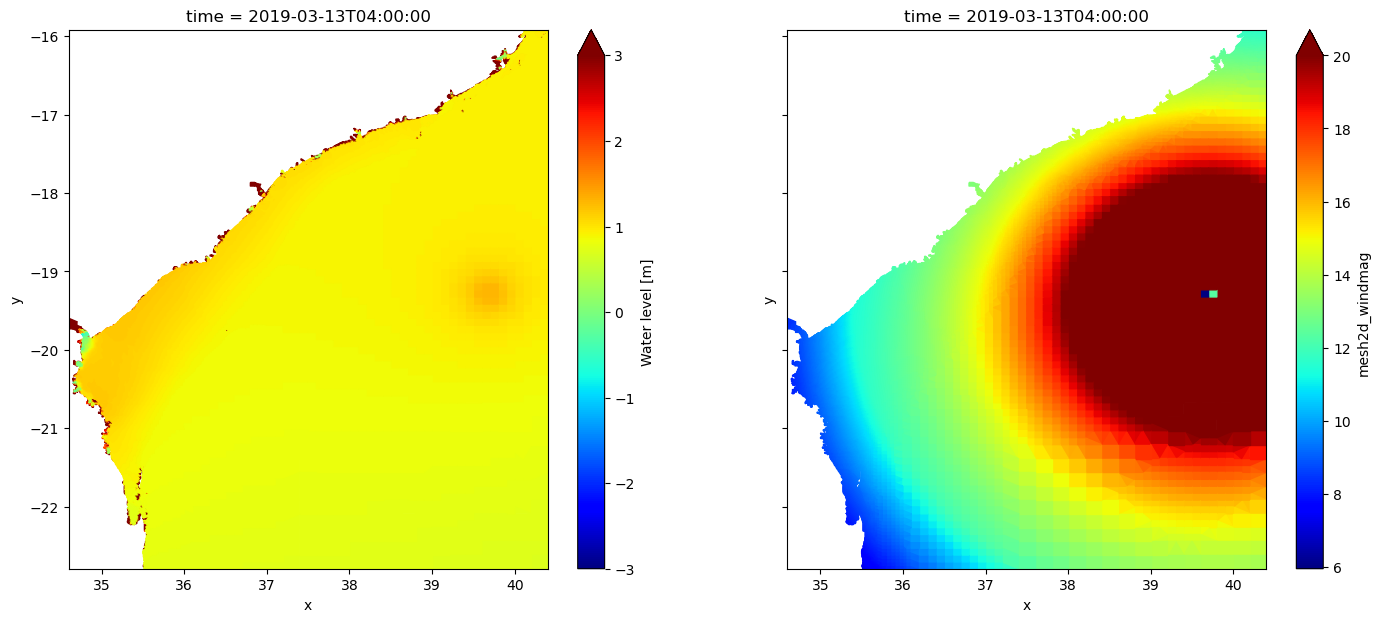

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(17,7),sharex=True,sharey=True)

pl_wl = ds_map['mesh2d_s1'].isel(time=100).ugrid.plot(ax=ax1, cmap='jet',vmax=3)
pl_wind = ds_map['mesh2d_windmag'].isel(time=100).ugrid.plot(ax=ax2, cmap='jet',vmax=20)

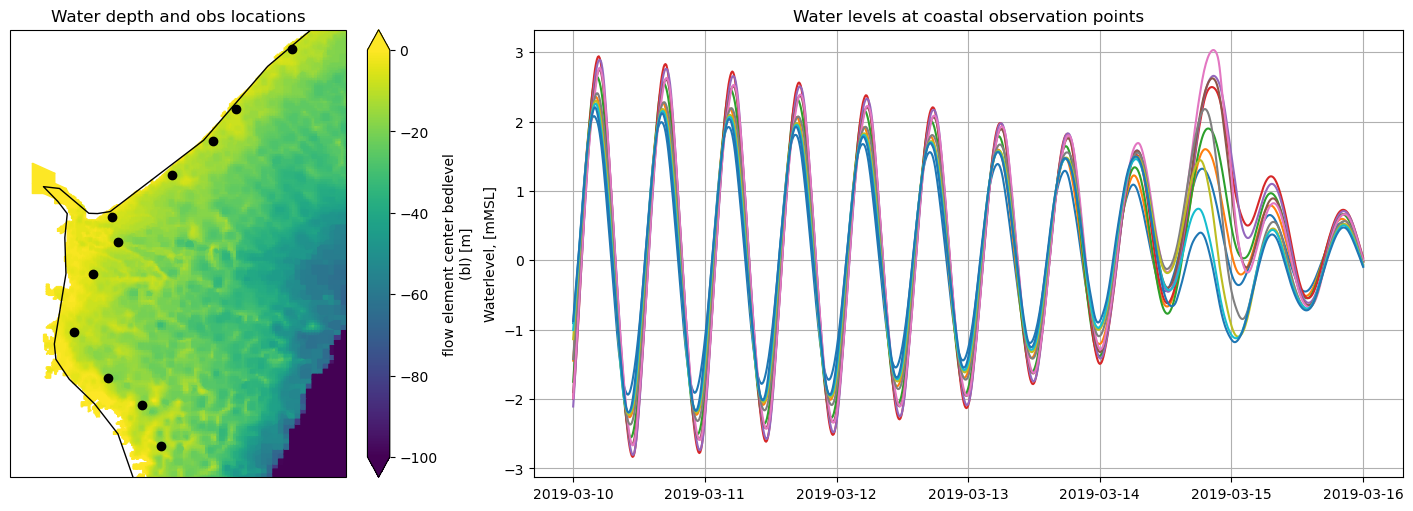

In [13]:
# make plot of timeseries at selected points
if "Kenneth" in model:
    box_extent = [40, 44,-15.5, -10.7]
    dep_vmin=-100
elif "Idai" in model:
    box_extent = [34.5, 36,-21, -19]
    dep_vmin=-100
elif "Freddy" in model:
    box_extent = [40, 44,-15.5, -10.7]
    dep_vmin =-100

ds_his_sel = ds_his.isel(time=slice(48*3,len(ds_his.time.values)))
ds_his_sel = ds_his_sel.where((ds_his_sel.station_x_coordinate > box_extent[0]) & (ds_his_sel.station_x_coordinate < box_extent[1]) & (ds_his_sel.station_y_coordinate > box_extent[2]) & (ds_his_sel.station_y_coordinate < box_extent[3]),drop=True)

fig = plt.figure(layout="constrained",figsize=(15,5))
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())

# plot bathymetry
pc = ds_map['mesh2d_flowelem_bl'].ugrid.plot(ax=ax1, cmap='viridis',vmax=0,vmin=dep_vmin)
ax1.set_title('Water depth and obs locations')
ax1.coastlines(resolution='50m')

p_obs = ax1.scatter(ds_his_sel.station_x_coordinate, ds_his_sel.station_y_coordinate, c='k')#label=f'Obs location, depth={obs_depth} m')
ax1.set_extent(box_extent,crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(gs[0, 1:])
ax2.plot(ds_his_sel.time,ds_his_sel.waterlevel,label='')
#ax2.legend() 
ax2.set_ylabel('Waterlevel, [mMSL]')
ax2.grid()
ax2.set_title('Water levels at coastal observation points')

plt.savefig(os.path.join(r'p:\11210471-001-compass\02_Models\Delft3DFM\figures', f'{model}_waterlevels_TS.png'), dpi=225, bbox_inches="tight")


In [17]:
# requires ffmpeg install with "conda install ffmpeg -c conda-forge"

# Full plot

step = 1  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}

def update_plot(i, ds_map, pl_wl, pl_wind):
    t = pd.to_datetime(ds_map.isel(time=i).time.values)
    ax1.set_title(f"Water level at {t}")
    ax2.set_title(f"Wind magnitude at {t}")
    pl_wl.set_array(ds_map.isel(time=i)['mesh2d_s1'].values.ravel())
    pl_wind.set_array(ds_map.isel(time=i)['mesh2d_windmag'].values.ravel())

fig = plt.figure(figsize=(12, 5))

#projection = ccrs.epsg(32634)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

#osm_background = cimgt.OSM()
#geo_axes1.add_image(osm_background, 10)

pl_wl = ds_map['mesh2d_s1'].isel(time=0).ugrid.plot(ax=ax1, cmap='turbo',vmin=-3,vmax=3,cbar_kwargs=cbar_kwargs)
pl_wind = ds_map['mesh2d_windmag'].isel(time=0).ugrid.plot(ax=ax2, cmap='jet',vmin=0,vmax=20,cbar_kwargs=cbar_kwargs)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0,ds_map.time.size, step),
    interval=20,  # ms between frames
    fargs=(
        ds_map,
        pl_wl,
        pl_wind,
    ),
)
# to save to mp4
ani.save(os.path.join(r'p:\11210471-001-compass\02_Models\Delft3DFM\figures', f'{model}.mp4'), fps=1, dpi=100)
plt.close()

# to show in notebook:
#HTML(ani.to_html5_video())

In [16]:
# requires ffmpeg install with "conda install ffmpeg -c conda-forge"

# Zoomed in plot
if "Kenneth" in model:
    xlims = [40,44.5]
    ylims=[-16,-10]
elif "Idai" in model:
    xlims = [34.5,40]
    ylims=[-22,-16]

step = 1  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}

def update_plot(i, ds_map, pl_wl, pl_wind):
    t = pd.to_datetime(ds_map.isel(time=i).time.values)
    ax1.set_title(f"Water level at {t}")
    ax2.set_title(f"Wind magnitude at {t}")
    pl_wl.set_array(ds_map.isel(time=i)['mesh2d_s1'].values.ravel())
    pl_wind.set_array(ds_map.isel(time=i)['mesh2d_windmag'].values.ravel())
    ax1.set_xlim(xlims); ax1.set_ylim(ylims)
    ax2.set_xlim(xlims); ax2.set_ylim(ylims)

fig = plt.figure(figsize=(12, 5))

#projection = ccrs.epsg(32634)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

#osm_background = cimgt.OSM()
#geo_axes1.add_image(osm_background, 10)

pl_wl = ds_map['mesh2d_s1'].isel(time=0).ugrid.plot(ax=ax1, cmap='turbo',vmin=-3,vmax=3,cbar_kwargs=cbar_kwargs)
pl_wind = ds_map['mesh2d_windmag'].isel(time=0).ugrid.plot(ax=ax2, cmap='jet',vmin=0,vmax=20,cbar_kwargs=cbar_kwargs)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0,ds_map.time.size, step),
    interval=20,  # ms between frames
    fargs=(
        ds_map,
        pl_wl,
        pl_wind,
    ),
)
# to save to mp4
ani.save(os.path.join(r'p:\11210471-001-compass\02_Models\Delft3DFM\figures', f'{model}_ZoomIn.mp4'), fps=1, dpi=100)
plt.close()

# to show in notebook:
#HTML(ani.to_html5_video())